In [1]:
import nltk
from nltk.tokenize import sent_tokenize
from transformers import pipeline, set_seed
import pandas as pd
import numpy as np

In [2]:
df_org = pd.read_csv("/Users/jeongrokyu/CS-7641/data/other_data/dropna_processed.csv")

In [3]:
df_org.describe().apply(lambda s: s.apply('{0:.5f}'.format))


,_id,duration,likes,views
count,5631.00000,5631.00000,5631.00000,5631.00000
mean,25686.56846,707.69153,63362.76487,2130394.21399
std,29649.00711,521.17937,108900.28046,3679481.01792
min,1.00000,60.00000,17.00000,587.00000
25%,1642.50000,355.00000,20000.00000,678154.00000
50%,9807.00000,682.00000,41000.00000,1392074.00000
75%,50009.50000,926.50000,65000.00000,2182299.50000
max,95714.00000,20404.00000,2200000.00000,73389142.00000


5631
5576


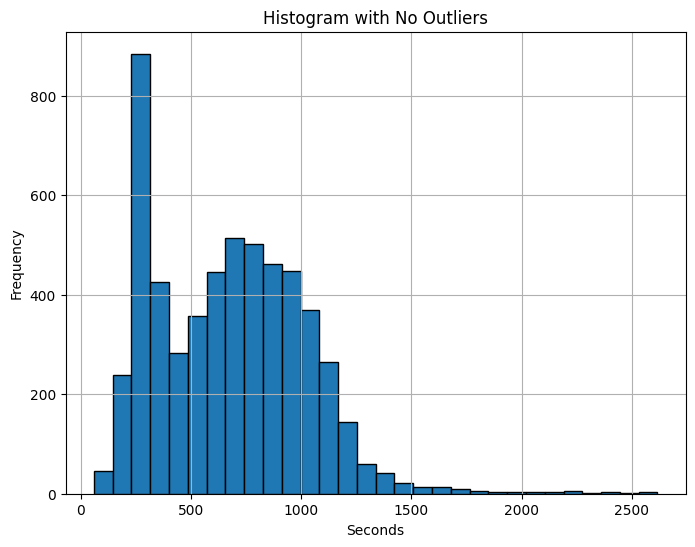

In [4]:
import matplotlib.pyplot as plt

# Generate some data with outliers
duration = df_org['duration']
# Excluding top 2 outliers: COUNTDOWN videos
# highest = duration.nlargest(2).index
# duration.drop(highest, inplace=True)
print(len(duration))
def remove_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    return data[(data >= lower_bound) & (data <= upper_bound)]

# Remove outliers
data_no_outliers = remove_outliers(duration)
print(len(data_no_outliers))

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(data_no_outliers, bins=30, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Seconds')
plt.ylabel('Frequency')
plt.title('Histogram with No Outliers')
plt.grid(True)
plt.show()


In [87]:
import plotly.express as px

fig = px.box(duration, y='duration', width=500)
fig.show()

In [ ]:
ranked_df = df_org['duration'].sort_values(ascending=False)
print(ranked_df[:100])

5631
5364


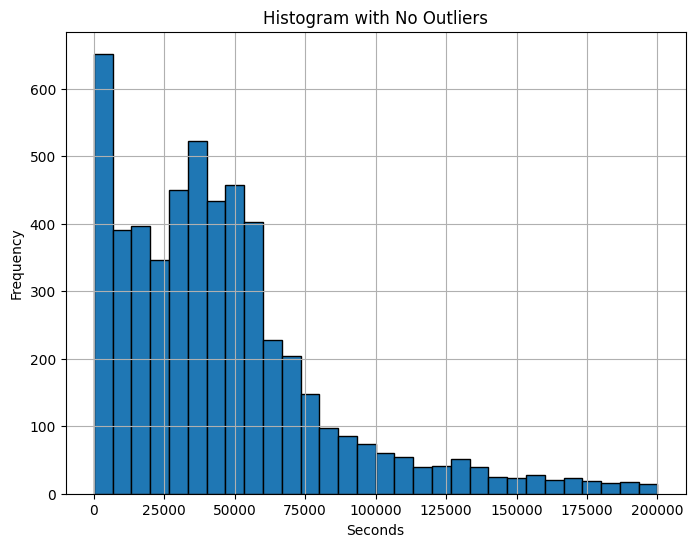

In [26]:
# Generate some data with outliers
likes = df_org['likes']
print(len(likes))
# ranked_df = df_org['likes'].sort_values(ascending=False)
# print(ranked_df[:125])

# Excluding top 2 outliers: COUNTDOWN videos
# highest = duration.nlargest(2).index
# duration.drop(highest, inplace=True)

def remove_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR # Empirical Rule states that 99.7% of the data is observed following a normal distribution lies within 3 standard deviations of the mean
    return data[(data >= lower_bound) & (data <= upper_bound)]

# Remove outliers
data_no_outliers = remove_outliers(likes)
print(len(data_no_outliers))

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(data_no_outliers, bins=30, edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Seconds')
plt.ylabel('Frequency')
plt.title('Histogram with No Outliers')
plt.grid(True)
plt.show()


In [85]:
fig = px.box(likes, y='likes', width=500)
fig.show()

In [86]:
views = df_org['views']
fig = px.box(views, y='views', width=500)
fig.show()

In [5]:
summary_and_transcript = df_org[['transcript', 'summary']]
print(len(summary_and_transcript))
summary_and_transcript.dropna()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(summary_and_transcript.iloc[4, 1])
print(len(summary_and_transcript.iloc[4, 1]))

5631
Jehane Noujaim unveils her 2006 TED Prize wish: to bring the world together for one day a year through the power of film.
121


In [6]:
drops = []
for i in range(len(summary_and_transcript)):
    if isinstance(summary_and_transcript.iloc[i,0],str):
        continue
    else:
        drops.append(i)
summary_and_transcript.drop(drops, inplace=True)
print(len(summary_and_transcript))

4983


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [7]:
print(type(summary_and_transcript.iloc[0,0]))

<class 'str'>


In [13]:
print(summary_and_transcript[:10][:])

                                          transcript  \
0  Over the past couple of days, as I've been pre...   
1  Thank you so much, Chris. And it's truly a gre...   
2  (Music: "The Sound of Silence," Simon &amp; Ga...   
3  We've been told to go out on a limb and say so...   
4  I can't help but this wish: to think about whe...   
5  I'd like to talk today about the two biggest s...   
6  I bet you're worried. (Laughter) I was worried...   
7  I'm often asked, "What surprised you about the...   
8  A public, Dewey long ago observed, is constitu...   
9  Good morning. How are you? (Audience) Good. It...   

                                             summary  
0  The founding mother of the blog revolution, Mo...  
1  With the same humor and humanity he exuded in ...  
2  New York Times columnist David Pogue takes aim...  
3  Legendary scientist David Deutsch puts theoret...  
4  Jehane Noujaim unveils her 2006 TED Prize wish...  
5  Anthropologist Helen Fisher takes on a tricky ... 

In [8]:
%pip install sumy

Note: you may need to restart the kernel to use updated packages.


In [93]:
summary_and_transcript.iloc[0,1]

"The founding mother of the blog revolution, Movable Type's Mena Trott, talks about the early days of blogging, when she realized that giving regular people the power to share our lives online is the key to building a friendlier, more connected world."

In [14]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer
# Preliminary results using Sumy module 
def summarize_text(text, num_sentences=15):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = LexRankSummarizer()
    summary = summarizer(parser.document, num_sentences)
    return " ".join(str(sentence) for sentence in summary)

# Example usage
original_text = summary_and_transcript.iloc[9,0]
print(original_text)
summary = summarize_text(original_text)
print("Summary:", summary)

Good morning. How are you? (Audience) Good. It's been great, hasn't it? I've been blown away by the whole thing. In fact, I'm leaving. (Laughter) There have been three themes running through the conference, which are relevant to what I want to talk about. One is the extraordinary evidence of human creativity in all of the presentations that we've had and in all of the people here; just the variety of it and the range of it. The second is that it's put us in a place where we have no idea what's going to happen in terms of the future. No idea how this may play out. I have an interest in education. Actually, what I find is, everybody has an interest in education. Don't you? I find this very interesting. If you're at a dinner party, and you say you work in education -- actually, you're not often at dinner parties, frankly. (Laughter) If you work in education, you're not asked. (Laughter) And you're never asked back, curiously. That's strange to me. But if you are, and you say to somebody, 

In [10]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jeongrokyu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Takes only upto 512 tokens

pipe = pipeline("summarization", model="t5-large")
pipe_out = pipe(sample)
summaries = {}
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

In [ ]:
pipe = pipeline("summarization", model="facebook/bart-large-xsum")
pipe_out = pipe(sample)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

In [ ]:
pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample)
summaries["pegasus"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

In [102]:
print("Ground Truth")
print(df_org['summary'][0])
print("")
for model in summaries:
    print(model.upper())
    print(summaries[model])
    print("")

Ground Truth
The founding mother of the blog revolution, Movable Type's Mena Trott, talks about the early days of blogging, when she realized that giving regular people the power to share our lives online is the key to building a friendlier, more connected world.

T5
cnn's john sutter talks about the power of blogs and social media .
he talks about how he started a blog when he was 23 and how it has changed his life .
blogs have changed the way we read news and consume media, he says .
"blogging is an amazing thing," and it's something we can do to help others .



In [15]:
from transformers import AutoTokenizer

model_checkpoint = "google/mt5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
inputs = tokenizer(summary_and_transcript.iloc[0,0])
print(inputs)


TypeError: Couldn't build proto file into descriptor pool: duplicate file name (sentencepiece_model.proto)

In [16]:
from transformers import BartTokenizer, BartForConditionalGeneration

# Load pre-trained model and tokenizer
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer
# Preliminary results using Sumy module 
def summarize_text(text, num_sentences=15):
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = LexRankSummarizer()
    summary = summarizer(parser.document, num_sentences)
    return " ".join(str(sentence) for sentence in summary)

# Example usage



# Long text to summarize
long_text = summary_and_transcript.iloc[9,0]
# Define maximum token length for each chunk
max_token_length = 1024

# Split the long text into chunks
ted_talks = [long_text[i:i+max_token_length] for i in range(0, len(long_text), max_token_length)]

# Generate summaries for each chunk
summaries = []
for sentence in ted_talks:
    # Tokenize the chunk
    tokenized_chunk = tokenizer.encode(sentence, return_tensors="pt", max_length=max_token_length, truncation=True)
    
    # Generate summary for the chunk
    summary_ids = model.generate(tokenized_chunk, num_beams=4, min_length=30, max_length=200, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    summaries.append(summary)

# Concatenate summaries to form the final summary
final_summary = " ".join(summaries)

# Print the final summary
print("Final Summary:", final_summary)

Final Summary: Good morning. How are you? (Audience) Good. It's been great, hasn't it? I've been blown away by the whole thing. In fact, I'm leaving. (Laughter) There have been three themes running through the conference, which are relevant to what I want to talk about. Education is one of those things that goes deep with people, am I right? So I have a big interest in education, and I think we all do. We have a huge vested interest in it, partly because it's education that's meant to take us into this future that we can't grasp. novation. I mean, Sirena last night was a marvel, wasn't she? Just seeing what she could do. And she's exceptional, but I think she's not, so to speak, exceptional in the whole of childhood. What you have there is a person of extraordinary dedication who found a talent. When James Robinson was four, he was in the Nativity play in England. "We considered this to be one of the lead parts. We had the place crammed full of agents in T-shirts" , "You OK with that?"

In [180]:
finals = [final_summary[i:i+max_token_length] for i in range(0, len(final_summary), max_token_length)]
result = []
for final in finals:
    tokenized_final = tokenizer.encode(final, return_tensors='pt', max_length=1024, truncation=True)
    summary_idx = model.generate(tokenized_final, num_beams=4, min_length=30, max_length= 100, early_stopping=True)
    summary_f = tokenizer.decode(summary_idx[0], skip_special_tokens=True)
    result.append(summary_f)
result_str = " ".join(result)

tokenize = tokenizer.encode(result_str, return_tensors='pt', max_length=1024, truncation=True)
summ = model.generate(tokenize,num_beams=4, min_length=30, max_length= 150, early_stopping=True)
summ_d = tokenizer.decode(summ[0], skip_special_tokens=True)
print(summ_d)

"I have a big interest in education, and I think we all do" There isn't an education system on the planet that teaches dance every day to children. Art and music are normally given a higher status in schools than drama and dance.


In [172]:
print(len(result_str))

1108


In [171]:
print(summary_and_transcript.iloc[9,1])
print(len(summary_and_transcript.iloc[9,1]))

Sir Ken Robinson makes an entertaining and profoundly moving case for creating an education system that nurtures (rather than undermines) creativity.
149


In [178]:
tokenized_final = tokenizer.encode(summary, return_tensors='pt', max_length=1024, truncation=True)
summary_idx = model.generate(tokenized_final, num_beams=4, min_length=30, max_length= 200, early_stopping=True)
summary_f = tokenizer.decode(summary_idx[0], skip_special_tokens=True)
print(summary_f)

One is the extraordinary evidence of human creativity in all of the presentations that we've had. If you're not prepared to be wrong, you'll never come up with anything original. You'd think it would be otherwise, but it isn't.
